<a href="https://colab.research.google.com/github/Renitacecilia/BreakHist-Dataset-Image-Classification/blob/master/Copy_of_Research_GANs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'breakhis:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F209316%2F999617%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240610%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240610T201433Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D631e754fff89d3c28caca37bcb81ccb61e8d05e1e06545562a9fe3a43cfe2640f42591b7d3c93da7b7317060ff7914367d4b7a4eb126e34d5d0a8d78af25904b473d4e818f5a544d25c0198ddad1bd7a595e572ca5ae2d7d5cabea259a76b5e0e80f01896ba53ac97534daccb18420e651514f89f2f43941a92dcb8bd51631f355d591d10f70d5b0bc069f770676e284be6929fcf920bb3554e8749f4c70dbf0289ff8b210e117a478355e95e1a6ffdf9d4e8ed20be6fcf24064867698d3aa1d57f19da8dc407619d5be04a1dda3da98102ca236781e381a57c1fbb3c6e9ba97550510f8f74cb2ce0931c4de44dba129a1d142dd44684315e856219cace912ea'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 4278955708 bytes downloaded
Downloaded and uncompressed: breakhis
Data source import complete.


In [ ]:
!pip install tensorflow


In [ ]:
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.activations import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.layers import Reshape

import seaborn as sns
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import os
from os import listdir
from tqdm import tqdm
import shutil
import cv2

from tensorflow.keras import Model
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import Callback, LearningRateScheduler

from math import *

from tensorflow.keras.models import load_model


In [ ]:
import tensorflow as tf

print(tf.__version__)      # This will print the TensorFlow version
print(tf.keras.__file__)   # This will show where Keras is located within TensorFlow
!nvidia-smi                # This will show the GPU details



2.15.0
/usr/local/lib/python3.10/dist-packages/keras/api/_v2/keras/__init__.py
/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
#intersection over union
def iou(y_true, y_pred, smooth = 0.5):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

# Computing Sensitivity
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

# Computing Specificity
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

# Define Dice coefficient metric
def dice_coefficient(y_true, y_pred, epsilon=1e-6):
    y_true_flat = tf.reshape(y_true, [-1])
    y_pred_flat = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_flat * y_pred_flat)
    dice_score = (2.0 * intersection + epsilon) / (tf.reduce_sum(y_true_flat) + tf.reduce_sum(y_pred_flat) + epsilon)
    return dice_score

def tversky(y_true, y_pred, smooth=1, alpha=0.7):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1 - y_pred_pos))
    false_pos = K.sum((1 - y_true_pos) * y_pred_pos)
    return (true_pos + smooth) / (true_pos + alpha * false_neg + (1 - alpha) * false_pos + smooth)

def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true, y_pred)

def focal_tversky_loss(y_true, y_pred, gamma=0.75):
    tv = tversky(y_true, y_pred)
    return K.pow((1 - tv), gamma)

In [ ]:
def confusion_matrix_img(y_pred, y_true, savename):
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred)
    labels = ['benign', 'malignant']
    title='Confusion matrix'
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig(savename)
    plt.show()

In [ ]:
import tensorflow as tf

epochs = 50

earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=epochs,
                          verbose=1,
                          restore_best_weights=True
                          )

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=5,
                              verbose=1,
                              min_delta=0.0001)
csv_logger = tf.keras.callbacks.CSVLogger('Model.log')

callbacks = [earlystop, csv_logger, reduce_lr]


In [ ]:
import os

size = 128

# Create directories if they do not exist
if not os.path.exists('augmented'):
    os.mkdir('augmented')
if not os.path.exists('./augmented/benign'):
    os.mkdir('./augmented/benign')
if not os.path.exists('./augmented/malignant'):
    os.mkdir('./augmented/malignant')


In [ ]:
def getListOfFiles(dirName):
    listOfFile = os.listdir(dirName)
    allFiles = list()
    for entry in listOfFile:
        fullPath = os.path.join(dirName, entry)
        if os.path.isdir(fullPath):
            allFiles = allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)

    return allFiles

In [ ]:
files_benign = getListOfFiles('../input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign')
for f in files_benign:
    if f.endswith('.png'):
        shutil.copy(f,'augmented/benign')

files_malignant = getListOfFiles('../input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/malignant')
for f in files_malignant:
    if f.endswith('.png'):
        shutil.copy(f,'augmented/malignant')

In [ ]:
benign_images = getListOfFiles('./augmented/benign')
malignent_images = getListOfFiles('./augmented/malignant')

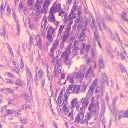

In [ ]:
tf.keras.utils.load_img(benign_images[9], target_size=(size,size,1), grayscale=False)

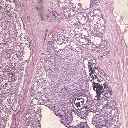

In [ ]:
tf.keras.utils.load_img(malignent_images[45], target_size=(size,size,1), grayscale=False)

In [ ]:
total_images = len(benign_images) + len(malignent_images)
total_images

7909

In [ ]:
data = pd.DataFrame(index=np.arange(0, len(benign_images)+len(malignent_images)), columns=["image", "target"])
k=0
for c in [0,1]:
        if c==1:
            for m in range(len(benign_images)):
                data.iloc[k]["image"] = benign_images[m]
                data.iloc[k]["target"] = 0
                k += 1
        else:
            for m in range(len(malignent_images)):
                data.iloc[k]["image"] = malignent_images[m]
                data.iloc[k]["target"] = 1
                k += 1
print(data.shape)
print(data.head())

(7909, 2)
                                               image target
0  ./augmented/malignant/SOB_M_DC-14-13993-400-01...      1
1  ./augmented/malignant/SOB_M_DC-14-20629-400-00...      1
2  ./augmented/malignant/SOB_M_DC-14-9461-100-007...      1
3  ./augmented/malignant/SOB_M_DC-14-5287-40-007.png      1
4  ./augmented/malignant/SOB_M_DC-14-16336-400-00...      1


In [ ]:
count_data = data["target"].value_counts()
count_data

target
1    5429
0    2480
Name: count, dtype: int64

In [ ]:
ben_upsampled = resample(data[data['target']==0],n_samples=data[data['target']==1].shape[0], random_state=42)
up_sampled = pd.concat([data[data['target']==1], ben_upsampled])
up_sampled['target'].value_counts()

target
1    5429
0    5429
Name: count, dtype: int64

In [ ]:
kf = KFold(n_splits=10,random_state=42, shuffle=True)
kf

KFold(n_splits=10, random_state=42, shuffle=True)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import KFold
from tqdm import tqdm

train_image = []
y = []

for i in tqdm(range(up_sampled.shape[0])):
    img = tf.keras.utils.load_img(up_sampled['image'].iloc[i], target_size=(size,size,1), grayscale=False)
    img = tf.keras.utils.img_to_array(img)
    img = img/255
    train_image.append(img)

X = np.array(train_image)
y = up_sampled.iloc[:,-1].values

kf = KFold(n_splits=10, random_state=42, shuffle=True)

for train_index, test_index in kf.split(X, y):
    X_train, X_test, y_train, y_test = X[train_index], X[test_index], \
                                       y[train_index], y[test_index]

for train_index, test_index in kf.split(X_test, y_test):
    X2_test, X_val, y2_test, y_val = X_test[train_index], X_test[test_index], \
                                      y_test[train_index], y_test[test_index]

Y_train = to_categorical(y_train, 2)
Y_test = to_categorical(y2_test, 2)
Y_val = to_categorical(y_val, 2)

print(X_train.shape)
print(X2_test.shape)
print(X_val.shape)


100%|██████████| 10858/10858 [03:00<00:00, 60.11it/s]


(9773, 128, 128, 3)
(977, 128, 128, 3)
(108, 128, 128, 3)


In [ ]:
my_input= Input(shape=(size, size, 3))
img_shape= (size, size, 3)

In [ ]:
data_gen = ImageDataGenerator(
        zoom_range=1.2,  # set range for random zoom
        rotation_range = 90,
        width_shift_range=0.5,
        height_shift_range=0.5,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
    )

In [ ]:
data_gen.fit(X_train)
X_train.shape[0]

9773

In [ ]:
data_gen.fit(X_val)
X_val.shape[0]

108

In [ ]:
data_gen.fit(X2_test)
X2_test.shape[0]

977

# Model

In [ ]:
#from keras.layers.advanced_activations import ELU
from keras.layers import ELU, PReLU, LeakyReLU,ThresholdedReLU

In [ ]:
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

Number of devices: 1


In [ ]:
# bottleneck section
def bottleneck0(inputs):
    backbone = tf.keras.applications.EfficientNetV2B0(weights='imagenet', include_top=False)
    x = backbone(inputs)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(256, activation='relu')(x)  # Bottleneck layer with EfficientNet
    x = Flatten()(x)
    return x

In [ ]:
def neck_section(inputs):
    x = Conv2D(256, (7, 7), strides=(2, 2), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('PReLU')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    x = Flatten()(x)

    return x


In [ ]:
# Vision Transform Section
def vision_transform(inputs, patch_size):

    # Reshape the input into patches
    x = Reshape((patch_size[0], patch_size[1], -1))(inputs)
    x = Lambda(lambda image: K.cast(image, 'float32') / 255.0)(x)

    # architecture for each patch processing
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)

    # Flatten the output
    x = Flatten()(x)

    return x

In [ ]:
# overall model incorporating patches in the vision transform section and the neck section
def model(input_shape, num_classes, patch_size):
    inputs = Input(shape=input_shape)

    efficientnet_bottleneck = bottleneck0(inputs)
    patches_transform = vision_transform(inputs, patch_size)
    neck = neck_section(inputs)

    # Merging the bottleneck, patches transform, and neck sections
    merged = tf.keras.layers.concatenate([efficientnet_bottleneck, patches_transform, neck])

    #bridge = Dense(64, activation='relu')(merged)

    outputs = Dense(num_classes, activation='softmax')(merged)

    model = Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
input_shape = (size, size, 3)  # Example input shape
num_classes = 2  # number of classes
patch_size = (32, 32)   # Size of the image patches
batch_size = 64

In [ ]:
with strategy.scope():
    model = model(input_shape, num_classes, patch_size)
    model.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
                metrics = (['accuracy', tf.keras.metrics.Precision(name='precision'),
                        tf.keras.metrics.Recall(name='recall'),
                        tf.keras.metrics.AUC(name='AUC'),
                        f1_score, specificity, sensitivity, iou,tversky]))

print(model.input_shape)
print(model.output_shape)
model.summary()

(None, 128, 128, 3)
(None, 2)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 reshape (Reshape)           (None, 32, 32, 48)           0         ['input_2[0][0]']             
                                                                                                  
 lambda (Lambda)             (None, 32, 32, 48)           0         ['reshape[0][0]']             
                                                                                                  
 conv2d (Conv2D)             (None, 30, 30, 64)           27712     ['lambda[0][0]']              
                                                                

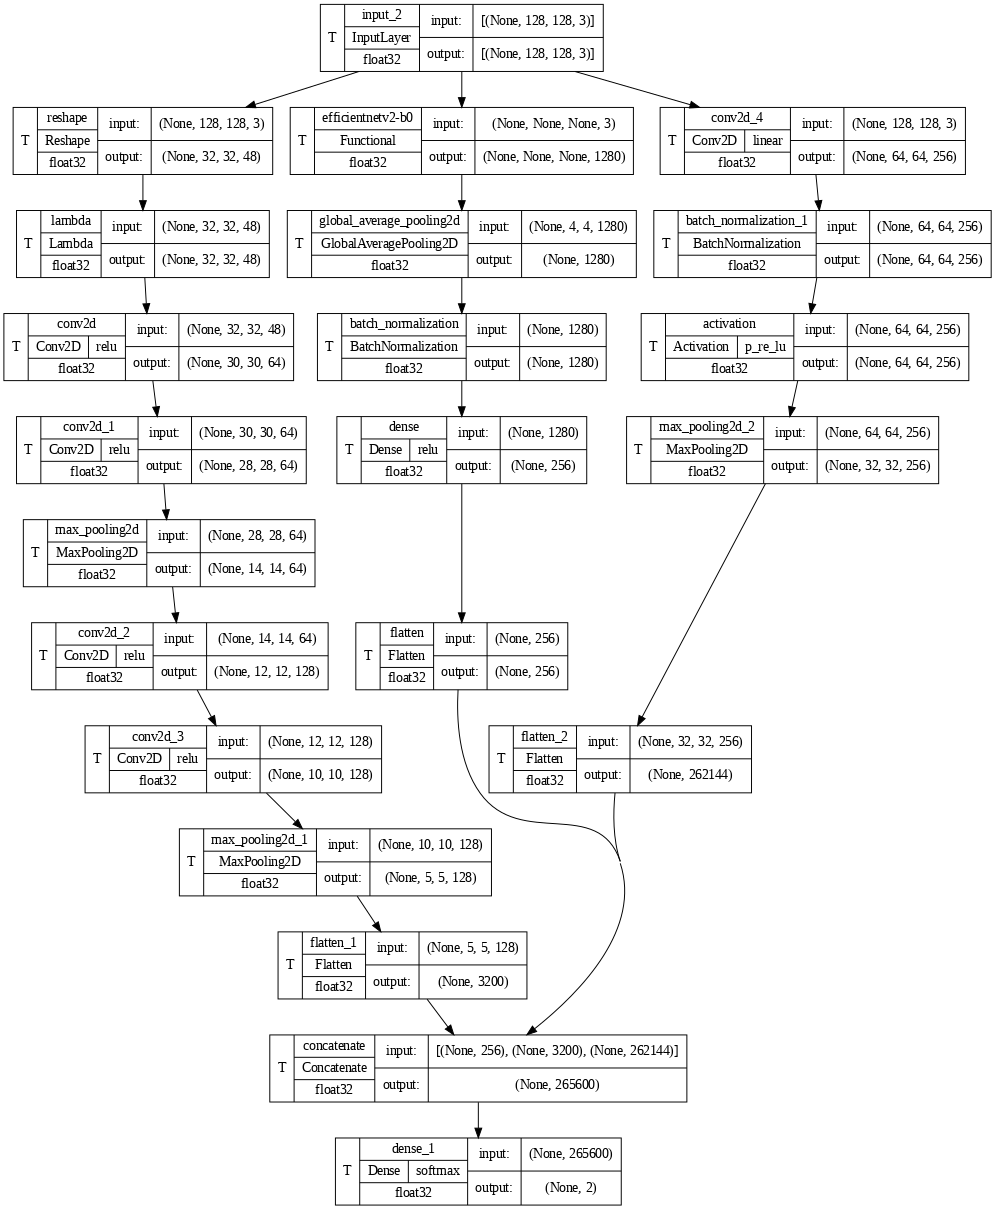

In [ ]:
tf.keras.utils.plot_model(model,
           show_shapes = True,
           show_dtype= True,
           show_layer_names = True,
           show_layer_activations= True,
            show_trainable= True,
           rankdir = 'TB',
           expand_nested = False,
           dpi = 70)

In [ ]:
%%time
history = model.fit(data_gen.flow(X_train,Y_train,
                                       batch_size = batch_size,
                                       seed=27,
                                       shuffle=True),
                    callbacks = callbacks,
                    epochs=5,
                    steps_per_epoch = X_train.shape[0] // batch_size,
                    validation_data =(data_gen.flow(X_val,Y_val,
                                       batch_size = batch_size,
                                       seed=27,
                                       shuffle=True)))

Epoch 1/5
 99/152 [==================>...........] - ETA: 8:56 - loss: 5.4425 - accuracy: 0.7019 - precision: 0.7019 - recall: 0.7019 - AUC: 0.7342 - f1_score: 0.7025 - specificity: 0.7025 - sensitivity: 0.7025 - iou: 0.5508 - tversky: 0.7057

In [ ]:
model.save("modelBH.h5")
print("Saved model to disk")

NameError: name 'model' is not defined

In [ ]:
import pandas as pd
df = pd.DataFrame(history.history)
df.to_excel("output.xlsx")
#df.to_csv("output1.csv")
df.head(50)

In [ ]:
# Interpreting the Metrics
fig, ax = plt.subplots(5, 2, figsize=(15, 30))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss', 'precision', 'recall', 'AUC', 'f1_score','sensitivity', 'specificity','iou', 'tversky']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])
plt.savefig("Model-Results.png")

In [ ]:
Test_data =(data_gen.flow(X2_test,Y_test,
                                       batch_size=128,
                                       seed=27,
                                       shuffle=True))

In [ ]:
%%time
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(Test_data, batch_size=32, callbacks= callbacks)
print("test loss test acc:", results)

In [ ]:
truey=[]
predy=[]
x = X2_test
y = Y_test

yhat= model.predict(x)
yh = yhat.tolist()
yt = y.tolist()
count = 0

for i in range(len(y)):
    yy = max(yh[i])
    yyt = max(yt[i])
    predy.append(yh[i].index(yy))
    truey.append(yt[i].index(yyt))
    if(yh[i].index(yy)== yt[i].index(yyt)):
        count+=1

acc = (count/len(y))*100

#saving values for confusion matrix and analysis
np.save('truey', truey)
np.save('predy', predy)
print("Predicted and true label values saved")
print("Accuracy on test set :"+str(acc)+"%")

In [ ]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


confusion_matrix_img(truey, predy, savename='Confusion Matrix')

In [ ]:
%%time
model0 = tf.keras.models.load_model('modelBH.h5',
                                           compile=False,
                                           custom_objects={
                                                'Accuracy': 'accuracy',
                                                'Precision': tf.keras.metrics.Precision(),
                                                'Recall': tf.keras.metrics.Recall(),
                                                'F1_Score': f1_score,})

model0.compile(Adam(learning_rate=0.001, amsgrad=True),
              loss = "categorical_crossentropy")